# Problem statement

While every day should be Mothers' Day [’cuz they rock], we are all guilty of taking to social media to post mushy messages or images on the second Sunday of May for our mothers. However, the Human Resources team of your organization wishes to celebrate and honor all moms currently employed at the company with a special monthly event. For one of such events, they have reached out to your team to curate and categorize Mothers’ Day-related tweets from across the globe.

As a Machine Learning Engineer, your task is to build a sophisticated sentiment analysis-based NLP model that can classify sentiments of tweets into positive, negative, and neutral.

# Dataset

The dataset consists of various parameters such as text and language of a tweet, the number of times it was retweeted, and the Twitter handle of the author.

The benefits of practicing this problem by using Machine Learning techniques are as follows:

This challenge will encourage you to apply your Machine Learning skills to build models that can process a receipt and output the total amount mentioned in it.
This challenge will help you enhance your knowledge of Natural Language Processing (NLP). NLP is one of the advanced fields of Machine Learning and Artificial Intelligence.
We challenge you to build a model that analyzes sentiments of a tweet and classifies them into positive, negative, and neutral.

In [5]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)


In [6]:
import re
import os
import nltk
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.corpus import wordnet
from collections import Counter
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer


warnings.filterwarnings('ignore')
tqdm_notebook.pandas()

C:\Users\HP\AppData\Local\Temp\ipykernel_9048\2293820135.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [7]:
# Import Dataset
train = pd.read_csv(r'C:\Users\HP\Desktop\train.csv')
test = pd.read_csv(r'C:\Users\HP\Desktop\test.csv')

In [8]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


(array([ 769.,    0.,    0.,    0.,    0., 1701.,    0.,    0.,    0.,
         765.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

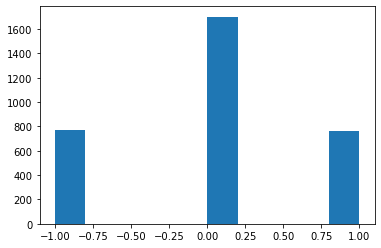

In [9]:
plt.hist(train['sentiment_class']) # dataset is imbalanced

In [10]:
test_id = test.id

In [11]:
# merge train and test set
train['train'] = "YES"
test['train'] = "NO"

In [12]:
all_data = pd.concat([train,test],ignore_index=True)

In [13]:
all_data.shape,train.shape, test.shape

((4622, 7), (3235, 7), (1387, 6))

In [14]:
all_data.tail()

,id,original_text,lang,retweet_count,original_author,sentiment_class,train
4617,1.245219e+18,Happy Mother’s Day you crazy bitch I’m sorry c...,en,0,MarlosFinds,NaN,NO
4618,1.245882e+18,"Mum can't get to the bingo, so we brought the ...",-0.8393813523,en,1,NaN,NO
4619,1.246461e+18,Despite all this bullshit today has been one o...,en,0,LToddWood,NaN,NO
4620,1.246245e+18,Happy Mothers Day Firstly to my Queen daniele_...,en,0,LToddWood,NaN,NO
4621,1.245178e+18,Mothers Day Walk When you live in a tiny villa...,en,0,HerHistoryatYC,NaN,NO


In [15]:
#function which are cleaning the texts from the dataset
def remove_no_space(text):
    REPLACE_NO_SPACE = re.compile("(\.)|(\t)|(\;)|(\:)|(\!)|(\?)|(\,)|(#)|(')|(\")|(\()|(\))|(\[)|(\])|(\d+)")
    NO_SPACE = ""
    return re.sub(REPLACE_NO_SPACE,NO_SPACE, text)
def remove_with_space(text):
    REPLACE_WITH_SPACE = re.compile("(<b\s*/><b\s*/>)|(\-)|(\/)|(\n)")
    SPACE = " "
    return re.sub(REPLACE_WITH_SPACE,SPACE, text)
def remove_access_space(text):
    return re.sub("\s\s+" , " ", text)

def remove_link(text):
  return re.sub(r'^https?:\/\/.*[\r\n]*', " ", text)

def lower_case(text):
    return text.lower()

In [16]:
all_data['original_text'] = all_data['original_text'].progress_apply(lower_case)
all_data['original_text'] = all_data['original_text'].progress_apply(remove_link)
all_data['original_text'] = all_data['original_text'].progress_apply(remove_with_space)
all_data['original_text'] = all_data['original_text'].progress_apply(remove_no_space)
all_data['original_text'] = all_data['original_text'].progress_apply(remove_access_space)


  0%|          | 0/4622 [00:00<?, ?it/s]

  0%|          | 0/4622 [00:00<?, ?it/s]

  0%|          | 0/4622 [00:00<?, ?it/s]

  0%|          | 0/4622 [00:00<?, ?it/s]

  0%|          | 0/4622 [00:00<?, ?it/s]

In [17]:
# converting into categories
all_data.loc[all_data['lang']!='en','lang'] = 0
all_data.loc[all_data['lang']=='en','lang'] = 1

In [18]:
all_data.loc[all_data['retweet_count']=='en','retweet_count'] = 0
all_data.loc[all_data['retweet_count']=='encouraging- thanks. more2come','retweet_count'] = 0
all_data.loc[all_data['retweet_count']==' have no other means of occasional transportation! Mary.','retweet_count'] = 0
all_data.loc[all_data['retweet_count']==' Shop &lt','retweet_count'] = 0
all_data.loc[all_data['retweet_count']==' He\'s told me I don\'t understand what it means to be a special agent LOL','retweet_count'] = 0
all_data.loc[all_data['retweet_count']==' Day//Gift for Moms//Personalized Shirt','retweet_count'] = 0
all_data.loc[all_data['retweet_count']==' BLOOD OF PROTECTION AROUND YOU GUYS','retweet_count'] = 0

In [19]:
all_data['retweet_count'].fillna(0,inplace=True)

In [20]:
all_data['retweet_count'] = all_data['retweet_count'].astype(np.float16)

In [21]:
all_data.loc[all_data['retweet_count']< 1,'retweet_count'] = 0

In [22]:
#Split into train and test dataframes
train = all_data[all_data['train']=="YES"]
test = all_data[all_data['train']=="NO"]

In [23]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,train
0,1.245025e+18,happy mothersday to all you amazing mothers ou...,1,0.0,BeenXXPired,0.0,YES
1,1.245759e+18,happy mothers day mum im sorry i cant be there...,1,1.0,FestiveFeeling,0.0,YES
2,1.246087e+18,happy mothers day to all this doing a mothers ...,1,0.0,KrisAllenSak,-1.0,YES
3,1.244803e+18,happy mothers day to this beautiful womanroyal...,1,0.0,Queenuchee,0.0,YES
4,1.244876e+18,remembering the most amazing ladies who made m...,1,0.0,brittan17446794,-1.0,YES


In [24]:
all_data.shape

(4622, 7)

In [25]:
test.shape

(1387, 7)

In [26]:
test.reset_index(drop=True, inplace=True)

# Preparing train/test dataset :

In [27]:
train.drop(columns=['train'],inplace=True)
test.drop(columns=['train'],inplace=True)

## TrainSet

In [28]:
tfidf_vec = TfidfVectorizer(stop_words='english',
                            ngram_range=(1,4), 
                            analyzer='word',
                            max_df = .9,
                            use_idf=1, 
                            sublinear_tf=1, 
                            min_df = 20, 
                            strip_accents='ascii')

full_tfidf = tfidf_vec.fit_transform(train['original_text'].values.tolist() + test['original_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['original_text'].values.tolist())

In [29]:
train_tfidf.shape

(3235, 743)

### Used SVD for dimension reduction

In [30]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp)
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_svd.shape

(3235, 20)

In [31]:
train_svd.head()

,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,svd_word_8,svd_word_9,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19
0,0.142591,-0.152380,0.056124,0.191297,-0.109899,0.112765,-0.065901,0.052554,-0.111216,-0.032100,0.069978,0.010409,-0.057227,-0.020363,-0.107702,-0.031636,-0.068162,-0.014483,-0.041962,-0.126977
1,0.208979,-0.097381,-0.068372,-0.119101,-0.239203,-0.183643,0.014206,0.098559,0.044051,-0.024471,0.012790,0.051580,0.016684,0.028389,-0.013599,-0.031212,0.017041,0.006827,0.060292,-0.006049
2,0.157722,-0.136449,-0.025809,-0.026698,0.013887,-0.016746,-0.009696,0.012358,-0.021731,-0.068043,0.012956,-0.023452,-0.082886,-0.022577,-0.037181,-0.030758,-0.012114,-0.020762,-0.030915,-0.102981
3,0.239855,-0.129351,-0.150028,-0.081800,-0.027545,0.026165,0.040333,-0.398070,-0.183764,0.243514,-0.183247,0.521435,-0.190847,0.009463,0.015352,-0.084678,0.020559,-0.037752,-0.189654,0.026758
4,0.171479,-0.137448,0.024917,-0.048322,-0.089883,0.035509,0.002303,0.005112,0.024472,0.032253,0.018811,-0.002273,-0.006730,-0.023411,-0.021404,-0.012395,-0.016389,0.004871,0.054133,-0.012121


In [32]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,happy mothersday to all you amazing mothers ou...,1,0.0,BeenXXPired,0.0
1,1.245759e+18,happy mothers day mum im sorry i cant be there...,1,1.0,FestiveFeeling,0.0
2,1.246087e+18,happy mothers day to all this doing a mothers ...,1,0.0,KrisAllenSak,-1.0
3,1.244803e+18,happy mothers day to this beautiful womanroyal...,1,0.0,Queenuchee,0.0
4,1.244876e+18,remembering the most amazing ladies who made m...,1,0.0,brittan17446794,-1.0


In [33]:
train =  pd.concat([train,train_svd],axis=1)

In [34]:
X = train.drop(columns = ['id', 'original_text', 'original_author','sentiment_class'])
Y = train['sentiment_class']

In [35]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

In [36]:
X['lang'] = X['lang'].astype(np.int16)


In [37]:
X.head()

,lang,retweet_count,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,...,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19
0,1,0.0,0.142591,-0.152380,0.056124,0.191297,-0.109899,0.112765,-0.065901,0.052554,...,0.069978,0.010409,-0.057227,-0.020363,-0.107702,-0.031636,-0.068162,-0.014483,-0.041962,-0.126977
1,1,1.0,0.208979,-0.097381,-0.068372,-0.119101,-0.239203,-0.183643,0.014206,0.098559,...,0.012790,0.051580,0.016684,0.028389,-0.013599,-0.031212,0.017041,0.006827,0.060292,-0.006049
2,1,0.0,0.157722,-0.136449,-0.025809,-0.026698,0.013887,-0.016746,-0.009696,0.012358,...,0.012956,-0.023452,-0.082886,-0.022577,-0.037181,-0.030758,-0.012114,-0.020762,-0.030915,-0.102981
3,1,0.0,0.239855,-0.129351,-0.150028,-0.081800,-0.027545,0.026165,0.040333,-0.398070,...,-0.183247,0.521435,-0.190847,0.009463,0.015352,-0.084678,0.020559,-0.037752,-0.189654,0.026758
4,1,0.0,0.171479,-0.137448,0.024917,-0.048322,-0.089883,0.035509,0.002303,0.005112,...,0.018811,-0.002273,-0.006730,-0.023411,-0.021404,-0.012395,-0.016389,0.004871,0.054133,-0.012121


## TestSet

In [38]:
tfidf_vec = TfidfVectorizer(stop_words='english', 
                            ngram_range=(1,4), 
                            analyzer='word',
                            max_df = .9,
                            use_idf=1, 
                            sublinear_tf=1, 
                            min_df = 20, 
                            strip_accents='ascii')
full_tfidf = tfidf_vec.fit_transform(train['original_text'].values.tolist() + test['original_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['original_text'].values.tolist())

In [39]:
test_tfidf.shape

(1387, 743)

In [40]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp)
svd_obj.fit(full_tfidf)
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.shape

(1387, 20)

In [41]:
test =  pd.concat([test,test_svd],axis=1)

In [42]:
test = test.drop(columns = ['id', 'original_text', 'original_author','sentiment_class'])

In [43]:
test['lang'] = test['lang'].astype(np.int16)

In [44]:
test.head()

,lang,retweet_count,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,...,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19
0,1,0.0,0.150573,-0.096279,-0.065862,-0.071500,0.011518,-0.016554,0.021508,-0.017760,...,0.029698,-0.024034,-0.077392,0.004919,-0.015506,0.005484,-0.019027,-0.009367,0.031017,-0.026071
1,1,0.0,0.231312,-0.155000,0.399583,-0.186668,0.133369,0.017156,-0.127536,-0.048066,...,0.242719,0.124322,0.108632,-0.014335,0.111705,-0.058838,0.126004,-0.030071,0.064970,0.000496
2,1,0.0,0.224079,-0.166632,0.245525,-0.151250,0.055448,0.006220,-0.106101,-0.064758,...,0.010303,-0.047202,0.036940,0.073070,-0.028762,0.032588,0.036392,-0.103102,-0.068539,0.037923
3,1,1.0,0.215684,-0.195078,0.006516,0.001195,-0.214710,-0.217794,-0.019054,0.182546,...,-0.045442,0.174322,-0.012967,0.015251,0.129323,-0.051483,0.167226,-0.075372,0.061901,-0.044591
4,1,0.0,0.174001,-0.117727,-0.025903,0.072915,0.102213,0.000143,0.449074,0.019313,...,0.057220,-0.053531,0.059516,0.115248,-0.004839,-0.032197,0.023660,0.058082,0.065528,-0.004751


# Model Building

In [45]:
lgb = LGBMClassifier(learning_rate= 0.1, 
                     max_depth= 5, 
                     n_estimators= 500, 
                     num_leaves= 32,
                     objective='multiclass'
                     )

In [46]:
# Used 100 Kfold
kf = StratifiedKFold(n_splits = 100)
i=1
prediction= []
for model in [lgb]:
  for dev_index, val_index in kf.split(X,Y):
      print("iteration - ", i)
      dev_X, val_X = X.iloc[dev_index], X.iloc[val_index]
      dev_y, val_y = Y.iloc[dev_index], Y.iloc[val_index]
      model.fit(dev_X,dev_y)
      prediction.append(model.predict(test))
      i+=1

iteration -  1
iteration -  2
iteration -  3
iteration -  4
iteration -  5
iteration -  6
iteration -  7
iteration -  8
iteration -  9
iteration -  10
iteration -  11
iteration -  12
iteration -  13
iteration -  14
iteration -  15
iteration -  16
iteration -  17
iteration -  18
iteration -  19
iteration -  20
iteration -  21
iteration -  22
iteration -  23
iteration -  24
iteration -  25
iteration -  26
iteration -  27
iteration -  28
iteration -  29
iteration -  30
iteration -  31
iteration -  32
iteration -  33
iteration -  34
iteration -  35
iteration -  36
iteration -  37
iteration -  38
iteration -  39
iteration -  40
iteration -  41
iteration -  42
iteration -  43
iteration -  44
iteration -  45
iteration -  46
iteration -  47
iteration -  48
iteration -  49
iteration -  50
iteration -  51
iteration -  52
iteration -  53
iteration -  54
iteration -  55
iteration -  56
iteration -  57
iteration -  58
iteration -  59
iteration -  60
iteration -  61
iteration -  62
iteration -  63
i

In [47]:
# Use Mode of all predictions
pred = pd.DataFrame(prediction).mode(axis=0)

In [48]:
pred = pred.loc[0]

(array([ 220.,    0.,    0.,    0.,    0., 1018.,    0.,    0.,    0.,
         149.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

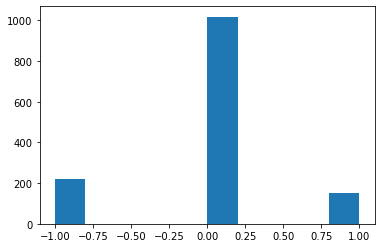

In [49]:
plt.hist(pred)

In [50]:
sb =  pd.DataFrame({'id':test_id,
                   'sentiment_class':pred})

In [51]:
sb.head()

,id,sentiment_class
0,1.246628e+18,0.0
1,1.245898e+18,0.0
2,1.244717e+18,1.0
3,1.245730e+18,-1.0
4,1.244636e+18,0.0


In [54]:
sb.to_csv('C:/Users/HP/Desktop/Submit_sol.csv',index=False)

# THANK YOU